# ufunc_reduce_all_f4
This notebook will build two modules in which the overlay is controlled using pybind11 and CFFI respectively. The `.so` files will be copied into the `zypy/lib/` folder so they can be used with ZyPy. The generic initalisation code is found below. After that, four implementatiations will be made and compared: the default NumPy one, the hardware accelerated version using PYNQ, the hardware accelerated version using pybind11 and the hardware accelerated version using CFFI. A timing analysis at the end will reveal the minimum stream size required for the accelerators to be more beneficial than the default NumPy implementation. To build and do the analysis, click on `Kernel > Restart & Run All`.

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")

N = 10_000

x1 = allocate(shape=(N), dtype="f4")
x2 = allocate(shape=(N), dtype="f4")
out = allocate(shape=(N), dtype="f4")

x1[:] = np.random.rand(*x1.shape) + 1
x2[:] = np.random.rand(*x1.shape) + 1
out[:] = np.zeros(out.shape)

# NumPy
This is just a wrapper around the default NumPy implementation. The wrapper is required so we can compare it in the timing analysis.

In [2]:
def add_reduce_all_f4_numpy(x1):
    return np.add.reduce(x1, axis = None)

def subtract_reduce_all_f4_numpy(x1):
    return np.subtract.reduce(x1, axis = None)

def multiply_reduce_all_f4_numpy(x1):
    return np.multiply.reduce(x1, axis = None)

def true_divide_reduce_all_f4_numpy(x1):
    return np.divide.reduce(x1, axis = None)

def logaddexp_reduce_all_f4_numpy(x1):
    return np.logaddexp.reduce(x1, axis = None)

def logaddexp2_reduce_all_f4_numpy(x1):
    return np.logaddexp2.reduce(x1, axis = None)

def dot_f4_numpy(x1, x2):
    return np.dot(x1, x2)

def sum_of_squares_f4_numpy(x1):
    return np.sum(x1 ** 2)

def sad_f4_numpy(x1, x2):
    return np.add.reduce(np.absolute(x1 - x2), axis = None)

out[:] = 0
print(f"add_reduce_all_f4_numpy = {add_reduce_all_f4_numpy(x1)}")

out[:] = 0
print(f"subtract_reduce_all_f4_numpy = {subtract_reduce_all_f4_numpy(x1)}")

out[:] = 0
print(f"multiply_reduce_all_f4_numpy = {multiply_reduce_all_f4_numpy(x1)}")

out[:] = 0
print(f"true_divide_reduce_all_f4_numpy = {true_divide_reduce_all_f4_numpy(x1)}")

out[:] = 0
print(f"logaddexp_reduce_all_f4_numpy = {logaddexp_reduce_all_f4_numpy(x1)}")

out[:] = 0
print(f"logaddexp2_reduce_all_f4_numpy = {logaddexp2_reduce_all_f4_numpy(x1)}")

out[:] = 0
print(f"dot_f4_numpy = {dot_f4_numpy(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_f4_numpy = {sum_of_squares_f4_numpy(x1)}")

out[:] = 0
print(f"sad_f4_numpy = {sad_f4_numpy(x1, x2)}")

add_reduce_all_f4_numpy = 14990.5
subtract_reduce_all_f4_numpy = -14987.7802734375
multiply_reduce_all_f4_numpy = inf
true_divide_reduce_all_f4_numpy = 1.401298464324817e-45
logaddexp_reduce_all_f4_numpy = 10.750917434692383
logaddexp2_reduce_all_f4_numpy = 14.815664291381836
dot_f4_numpy = 22489.185546875
sum_of_squares_f4_numpy = 23307.140625
sad_f4_numpy = 3344.060546875


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in reduce
  


# PYNQ
This is the default PYNQ implementation, in which the AXI4-Lite registers are controlled using the built-in MMIO module.

In [3]:
from struct import pack, unpack

NONE = 0
ADD = 1
MULTIPLY = 2
SQUARE = 3
EXP = 4
LOG = 5
ABSDIFF = 6
SUBTRACT = 7
TRUE_DIVIDE = 8
SIN = 9
SQRT = 10
ARCTAN = 11
SINH = 12

def to_float(u32):
    return unpack('f', pack('I', u32))[0]

def add_reduce_all_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out)

def subtract_reduce_all_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1, start=4)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return x1.flat[0] - to_float(out)

def multiply_reduce_all_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (MULTIPLY << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out)

def true_divide_reduce_all_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (MULTIPLY << 0) | (NONE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1, start=4)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return x1.flat[0] / to_float(out)

def logaddexp_reduce_all_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (EXP << 8) | (LOG << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out)

def logaddexp2_reduce_all_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (EXP << 8) | (LOG << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out) / np.log(2)

def dot_f4_pynq(x1, x2):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (MULTIPLY << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out)

def sum_of_squares_f4_pynq(x1):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (SQUARE << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out)

def sad_f4_pynq(x1, x2):
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x18, (ADD << 0) | (ABSDIFF << 8) | (NONE << 16))  # Set the args
    overlay.ufunc_reduce_all_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    while not (overlay.ufunc_reduce_all_f4_0.mmio.read(0x00) & 0x2): pass  # Wait until done

    out = overlay.ufunc_reduce_all_f4_0.mmio.read(0x10)

    return to_float(out)

out[:] = 0
print(f"add_reduce_all_f4_pynq = {add_reduce_all_f4_pynq(x1)}")

out[:] = 0
print(f"subtract_reduce_all_f4_pynq = {subtract_reduce_all_f4_pynq(x1)}")

out[:] = 0
print(f"multiply_reduce_all_f4_pynq = {multiply_reduce_all_f4_pynq(x1)}")

out[:] = 0
print(f"true_divide_reduce_all_f4_pynq = {true_divide_reduce_all_f4_pynq(x1)}")

out[:] = 0
print(f"logaddexp_reduce_all_f4_pynq = {logaddexp_reduce_all_f4_pynq(x1)}")

out[:] = 0
print(f"logaddexp2_reduce_all_f4_pynq = {logaddexp2_reduce_all_f4_pynq(x1)}")

out[:] = 0
print(f"dot_f4_pynq = {dot_f4_pynq(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_f4_pynq = {sum_of_squares_f4_pynq(x1)}")

out[:] = 0
print(f"sad_f4_pynq = {sad_f4_pynq(x1, x2)}")

add_reduce_all_f4_pynq = 14990.5009765625
subtract_reduce_all_f4_pynq = -14987.760064721107
multiply_reduce_all_f4_pynq = inf
true_divide_reduce_all_f4_pynq = 0.0
logaddexp_reduce_all_f4_pynq = 10.750920295715332
logaddexp2_reduce_all_f4_pynq = 15.510299395621018
dot_f4_pynq = 22489.19140625
sum_of_squares_f4_pynq = 23307.13671875
sad_f4_pynq = 3344.06005859375


# pybind11
This is the pybind11 implementation, in which all registers are controlled by `mmap`ing the physical memory `/dev/mem/`.

In [4]:
%%pybind11 ufunc_reduce_all_f4_pybind11

#include "defines.h"

#define NONE 0
#define ADD 1
#define MULTIPLY 2
#define SQUARE 3
#define EXP 4
#define LOG 5
#define ABSDIFF 6
#define SUBTRACT 7
#define TRUE_DIVIDE 8
#define SIN 9
#define SQRT 10
#define ARCTAN 11
#define SINH 12

float to_float(unsigned int val) {
    union {
        unsigned int u4;
        float f4;
    } data = {val};

    return data.f4;
}

float add_reduce_all_f4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_f4_0_args_args_w(((ADD << 0) | (NONE << 8) | (NONE << 16)));
    ufunc_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(ufunc_reduce_all_f4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float multiply_reduce_all_f4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_f4_0_args_args_w(((MULTIPLY << 0) | (NONE << 8) | (NONE << 16)));
    ufunc_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(ufunc_reduce_all_f4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float logaddexp_reduce_all_f4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_f4_0_args_args_w(((ADD << 0) | (EXP << 8) | (LOG << 16)));
    ufunc_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(ufunc_reduce_all_f4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float dot_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_f4_0_args_args_w(((ADD << 0) | (MULTIPLY << 8) | (NONE << 16)));
    ufunc_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(ufunc_reduce_all_f4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float sum_of_squares_f4(unsigned int x1_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_f4_0_args_args_w(((ADD << 0) | (SQUARE << 8) | (NONE << 16)));
    ufunc_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(ufunc_reduce_all_f4_0_ap_return_ap_return_r());

    exit();

    return res;
}

float sad_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes)
{
    init();

    ufunc_reduce_all_f4_0_args_args_w(((ADD << 0) | (ABSDIFF << 8) | (NONE << 16)));
    ufunc_reduce_all_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    while(!(ufunc_reduce_all_f4_0_ctrl_ap_done_r()));

    float res = to_float(ufunc_reduce_all_f4_0_ap_return_ap_return_r());

    exit();

    return res;
}

In [5]:
# This cell writes the above source code to a file, so that it can be reused for the CFFI implementation.
# Please make sure the cell above is the last cell executed!

with open(f"ufunc_reduce_all_f4.c", "w") as f:
    code = ("#" + _ih[-2].split("#", 1)[1])[:-2].replace("\\n", "\n")
    f.write(code)

In [6]:
import ufunc_reduce_all_f4_pybind11 as calc

def add_reduce_all_f4_pybind11(x1):
    return calc.add_reduce_all_f4(x1.physical_address, x1.nbytes)

def subtract_reduce_all_f4_pybind11(x1):
    return x1.flat[0] - calc.add_reduce_all_f4(x1.physical_address + 4, x1.nbytes - 4)

def multiply_reduce_all_f4_pybind11(x1):
    return calc.multiply_reduce_all_f4(x1.physical_address, x1.nbytes)

def true_divide_reduce_all_f4_pybind11(x1):
    return x1.flat[0] / calc.multiply_reduce_all_f4(x1.physical_address + 4, x1.nbytes - 4)

def logaddexp_reduce_all_f4_pybind11(x1):
    return calc.logaddexp_reduce_all_f4(x1.physical_address, x1.nbytes)

def logaddexp2_reduce_all_f4_pybind11(x1):
    return calc.logaddexp_reduce_all_f4(x1.physical_address, x1.nbytes) / np.log(2)

def dot_f4_pybind11(x1, x2):
    return calc.dot_f4(x1.physical_address, x2.physical_address, x1.nbytes)

def sum_of_squares_f4_pybind11(x1):
    return calc.sum_of_squares_f4(x1.physical_address, x1.nbytes)

def sad_f4_pybind11(x1, x2):
    return calc.sad_f4(x1.physical_address, x2.physical_address, x1.nbytes)

out[:] = 0
print(f"add_reduce_all_f4_pybind11 = {add_reduce_all_f4_pybind11(x1)}")

out[:] = 0
print(f"subtract_reduce_all_f4_pybind11 = {subtract_reduce_all_f4_pybind11(x1)}")

out[:] = 0
print(f"multiply_reduce_all_f4_pybind11 = {multiply_reduce_all_f4_pybind11(x1)}")

out[:] = 0
print(f"true_divide_reduce_all_f4_pybind11 = {true_divide_reduce_all_f4_pybind11(x1)}")

out[:] = 0
print(f"logaddexp_reduce_all_f4_pybind11 = {logaddexp_reduce_all_f4_pybind11(x1)}")

out[:] = 0
print(f"logaddexp2_reduce_all_f4_pybind11 = {logaddexp2_reduce_all_f4_pybind11(x1)}")

out[:] = 0
print(f"dot_f4_pybind11 = {dot_f4_pybind11(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_f4_pybind11 = {sum_of_squares_f4_pybind11(x1)}")

out[:] = 0
print(f"sad_f4_pybind11 = {sad_f4_pybind11(x1, x2)}")

add_reduce_all_f4_pybind11 = 14990.5009765625
subtract_reduce_all_f4_pybind11 = -14987.760064721107
multiply_reduce_all_f4_pybind11 = inf
true_divide_reduce_all_f4_pybind11 = 0.0
logaddexp_reduce_all_f4_pybind11 = 10.750920295715332
logaddexp2_reduce_all_f4_pybind11 = 15.510299395621018
dot_f4_pybind11 = 22489.19140625
sum_of_squares_f4_pybind11 = 23307.13671875
sad_f4_pybind11 = 3344.06005859375


# CFFI
This is the CFFI implementation, of which the source code is identical to the pybind11 implementation.
The only thing that needs to be added are the C definitions.

In [7]:
%%writefile build_ufunc_reduce_all_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

# Add all C definitions below...

ffibuilder.cdef(
    r"""
float add_reduce_all_f4(unsigned int x1_addr, unsigned int nbytes);
float multiply_reduce_all_f4(unsigned int x1_addr, unsigned int nbytes);
float logaddexp_reduce_all_f4(unsigned int x1_addr, unsigned int nbytes);
float dot_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes);
float sum_of_squares_f4(unsigned int x1_addr, unsigned int nbytes);
float sad_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int nbytes);
    """
)

with open("ufunc_reduce_all_f4.c") as f:
    ffibuilder.set_source("ufunc_reduce_all_f4_cffi", f.read())

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing build_ufunc_reduce_all_f4_cffi.py


In [8]:
%%bash

/home/xilinx/perf_env/bin/python  build_ufunc_reduce_all_f4_cffi.py
cp ufunc_reduce_all_f4_cffi.cpython-37m-arm-linux-gnueabihf.so ../
cp ufunc_reduce_all_f4_pybind11.so ../

generating ./ufunc_reduce_all_f4_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/zypy/lib/ufunc_reduce_all_f4'
running build_ext
building 'ufunc_reduce_all_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c ufunc_reduce_all_f4_cffi.c -o ./ufunc_reduce_all_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./ufunc_reduce_all_f4_cffi.o -o ./ufunc_reduce_all_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In file included from ufunc_reduce_all_f4_cffi.c:569:0:
defines.h:172:15: warning: backslash-newline at end of file
 #define exit()\
                


In [9]:
from ufunc_reduce_all_f4_cffi import lib as calc

def add_reduce_all_f4_cffi(x1):
    return calc.add_reduce_all_f4(x1.physical_address, x1.nbytes)

def subtract_reduce_all_f4_cffi(x1):
    return x1.flat[0] - calc.add_reduce_all_f4(x1.physical_address + 4, x1.nbytes - 4)

def multiply_reduce_all_f4_cffi(x1):
    return calc.multiply_reduce_all_f4(x1.physical_address, x1.nbytes)

def true_divide_reduce_all_f4_cffi(x1):
    return x1.flat[0] / calc.multiply_reduce_all_f4(x1.physical_address + 4, x1.nbytes - 4)

def logaddexp_reduce_all_f4_cffi(x1):
    return calc.logaddexp_reduce_all_f4(x1.physical_address, x1.nbytes)

def logaddexp2_reduce_all_f4_cffi(x1):
    return calc.logaddexp_reduce_all_f4(x1.physical_address, x1.nbytes) / np.log(2)

def dot_f4_cffi(x1, x2):
    return calc.dot_f4(x1.physical_address, x2.physical_address, x1.nbytes)

def sum_of_squares_f4_cffi(x1):
    return calc.sum_of_squares_f4(x1.physical_address, x1.nbytes)

def sad_f4_cffi(x1, x2):
    return calc.sad_f4(x1.physical_address, x2.physical_address, x1.nbytes)

out[:] = 0
print(f"add_reduce_all_f4_cffi = {add_reduce_all_f4_cffi(x1)}")

out[:] = 0
print(f"subtract_reduce_all_f4_cffi = {subtract_reduce_all_f4_cffi(x1)}")

out[:] = 0
print(f"multiply_reduce_all_f4_cffi = {multiply_reduce_all_f4_cffi(x1)}")

out[:] = 0
print(f"true_divide_reduce_all_f4_cffi = {true_divide_reduce_all_f4_cffi(x1)}")

out[:] = 0
print(f"logaddexp_reduce_all_f4_cffi = {logaddexp_reduce_all_f4_cffi(x1)}")

out[:] = 0
print(f"logaddexp2_reduce_all_f4_cffi = {logaddexp2_reduce_all_f4_cffi(x1)}")

out[:] = 0
print(f"dot_f4_cffi = {dot_f4_cffi(x1, x2)}")

out[:] = 0
print(f"sum_of_squares_f4_cffi = {sum_of_squares_f4_cffi(x1)}")

out[:] = 0
print(f"sad_f4_cffi = {sad_f4_cffi(x1, x2)}")

add_reduce_all_f4_cffi = 14990.5009765625
subtract_reduce_all_f4_cffi = -14987.760064721107
multiply_reduce_all_f4_cffi = inf
true_divide_reduce_all_f4_cffi = 0.0
logaddexp_reduce_all_f4_cffi = 10.750920295715332
logaddexp2_reduce_all_f4_cffi = 15.510299395621018
dot_f4_cffi = 22489.19140625
sum_of_squares_f4_cffi = 23307.13671875
sad_f4_cffi = 3344.06005859375


# Timing analysis
The timing analysis is done for each of the functions that is accelerated in hardware. The values of the stream size for which the hardware implementation provides acceleration are given by `pynq_min`, `pybind11_min` and `cffi_min` respectively. Equivalently `pynq_min_reconf`, `pybind11_min_reconf` and `cffi_min_recong` indicate the size required in case reconfiguration is taken into account as well.

## add_reduce_all_f4


kernel = numpy, n = 16, t = 0.0002017268
kernel = pynq, n = 16, t = 0.12950279150000002
kernel = pybind11, n = 16, t = 0.00028726550000000004
kernel = cffi, n = 16, t = 0.0002525443
kernel = numpy, n = 32, t = 0.0002025123
kernel = pynq, n = 32, t = 0.1286812761
kernel = pybind11, n = 32, t = 0.0003710126
kernel = cffi, n = 32, t = 0.0002608837
kernel = numpy, n = 64, t = 0.000208244
kernel = pynq, n = 64, t = 0.1288660859
kernel = pybind11, n = 64, t = 0.0002965871
kernel = cffi, n = 64, t = 0.0002590393
kernel = numpy, n = 128, t = 0.00021296310000000002
kernel = pynq, n = 128, t = 0.1292625974
kernel = pybind11, n = 128, t = 0.0003658379
kernel = cffi, n = 128, t = 0.0002600803
kernel = numpy, n = 256, t = 0.0002379667
kernel = pynq, n = 256, t = 0.12984986720000002
kernel = pybind11, n = 256, t = 0.0003019313
kernel = cffi, n = 256, t = 0.0002626815
kernel = numpy, n = 512, t = 0.00027342990000000004
kernel = pynq, n = 512, t = 0.12922450040000003
kernel = pybind11, n = 512, t = 0.

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.2607925e-05      │ 0.00809392446875… │ 1.795409375000000… │ 1.578401875e-05   │
│ 32      │ 6.328509375e-06    │ 0.004021289878125 │ 1.159414375e-05    │ 8.152615625e-06   │
│ 64      │ 3.2538125e-06      │ 0.00201353259218… │ 4.6341734375e-06   │ 4.0474890625e-06  │
│ 128     │ 1.663774218750000… │ 0.00100986404218… │ 2.85810859375e-06  │ 2.03187734375e-06 │
│ 256     │ 9.29557421875e-07  │ 0.00050722604375… │ 1.179419140625e-06 │ 1.026099609375e-… │
│ 512     │ 5.340427734375001… │ 0.00025239160234… │ 2.78984375e-07     │ 5.2849765625e-07  │
│ 1024    │ 3.2145126953125e-… │ 0.00012624459677… │ 3.7151318359375e-… │ 2.750927734375e-… │
│ 2048    │ 2.097910156250000… │ 6.31726055175781… │ 1.945832519531250… │ 1.40881005859375… │
│ 4096    │ 1.62753759765625e… │ 3.20821126220703… │ 8.00298095703125e… │ 7.18545654296875… │
│ 8192    │ 1.362954101562500… │ 1.58080609008789… │ 5.434536132812500… │ 4.10494995117187… │
│ 16384   │ 1.242717041015625… │ 7.96749521484375… │ 3.141107177734375… │ 2.58508056640625… │
│ 32768   │ 1.182236206054687… │ 3.95777861328125… │ 1.788321533203125… │ 1.72838500976562… │
│ 65536   │ 1.143852157592773… │ 1.97148292694091… │ 2.125945587158203… │ 1.32334594726562… │
│ 131072  │ 1.129900672912597… │ 9.90874369812011… │ 1.114269104003906… │ 1.10686271667480… │
│ 262144  │ 1.14792582321167e… │ 4.95575252151489… │ 1.054348526000976… │ 1.05082431793212… │
│ 524288  │ 1.116119230270385… │ 2.47824277687072… │ 1.029764366149902… │ 1.02720983505249… │
│ 1048576 │ 1.111762998580932… │ 1.24255720615386… │ 1.014407138824463… │ 1.02294345855712… │
│ 2097152 │ 1.107607066154480… │ 6.23133904933929… │ 1.007308559417724… │ 1.00784804344177… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

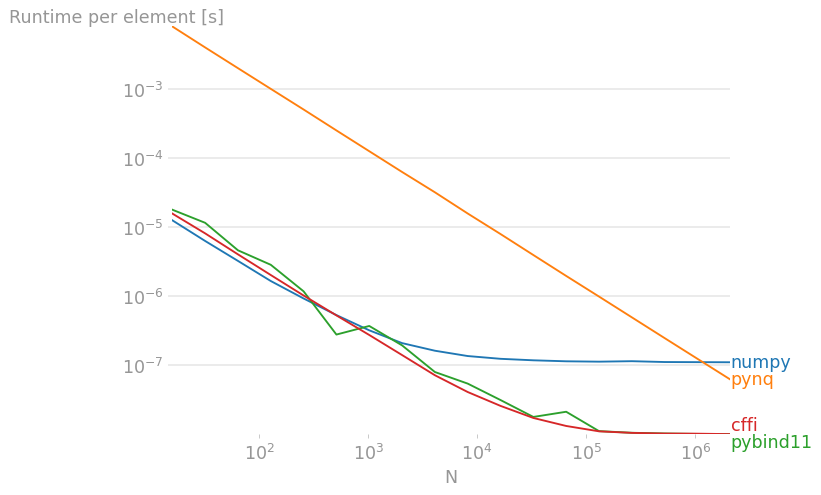

pynq_min = 1048576
pybind11_min = 1024
cffi_min = 256
Bitstream download time = 0.21866918700000001


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.2607925e-05      │ 0.02176074865625… │ 0.01368477828125   │ 0.01368260820625  │
│ 32      │ 6.328509375e-06    │ 0.010854701971875 │ 0.0068450062375    │ 0.006841564709375 │
│ 64      │ 3.2538125e-06      │ 0.00543023863906… │ 0.0034213402203125 │ 0.00342075353593… │
│ 128     │ 1.663774218750000… │ 0.00271821706562… │ 0.001711211132031… │ 0.00171038490078… │
│ 256     │ 9.29557421875e-07  │ 0.00136140255546… │ 0.000855355930859… │ 0.00085520261132… │
│ 512     │ 5.340427734375001… │ 0.00067947985820… │ 0.000427367240234… │ 0.00042761675351… │
│ 1024    │ 3.2145126953125e-… │ 0.00033978872470… │ 0.000213915641113… │ 0.00021381922070… │
│ 2048    │ 2.097910156250000… │ 0.00016994466948… │ 0.000106966647216… │ 0.00010691294497… │
│ 4096    │ 1.62753759765625e… │ 8.54681446044922… │ 5.346606179199219… │ 5.34578865478515… │
│ 8192    │ 1.362954101562500… │ 4.25010768920898… │ 2.674736135253906… │ 2.67340654907226… │
│ 16384   │ 1.242717041015625… │ 2.13140032104492… │ 1.337791906738281… │ 1.33723588012695… │
│ 32768   │ 1.182236206054687… │ 1.06310326110839… │ 6.691137213134766… │ 6.69053784790039… │
│ 65536   │ 1.143852157592773… │ 5.30810992584228… │ 3.357886454772949… │ 3.34986045837402… │
│ 131072  │ 1.129900672912597… │ 2.65918786926269… │ 1.679456190490722… │ 1.67938212661743… │
│ 262144  │ 1.14792582321167e… │ 1.32973200187683… │ 8.447002349853517… │ 8.44664992904663… │
│ 524288  │ 1.116119230270385… │ 6.64902652549743… │ 4.273760185241699… │ 4.27350473213195… │
│ 1048576 │ 1.111762998580932… │ 3.32794908046722… │ 2.186832588195801… │ 2.18768622016906… │
│ 2097152 │ 1.107607066154480… │ 1.66582984209060… │ 1.143426793098449… │ 1.14348074150085… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

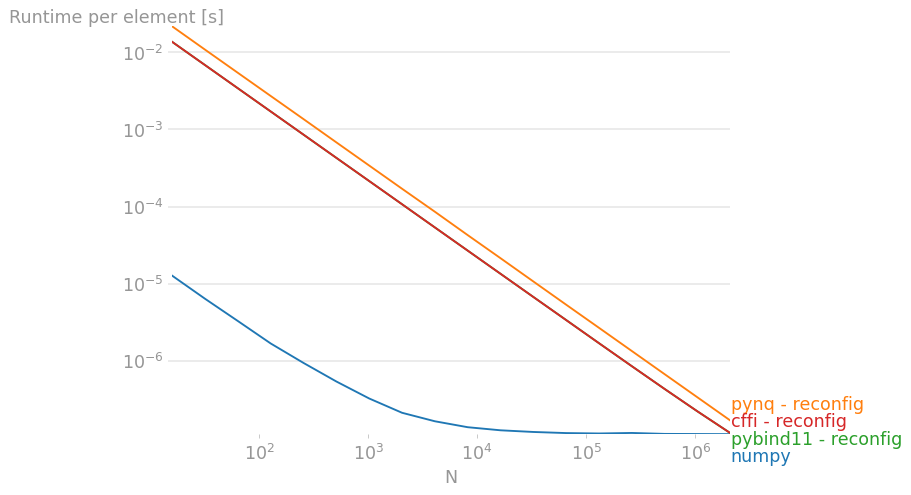

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [10]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n,), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [add_reduce_all_f4_numpy, add_reduce_all_f4_pynq, add_reduce_all_f4_pybind11, add_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## subtract_reduce_all_f4


kernel = numpy, n = 16, t = 0.0002268759
kernel = pynq, n = 16, t = 0.1292566062
kernel = pybind11, n = 16, t = 0.0004767756
kernel = cffi, n = 16, t = 0.0003638067
kernel = numpy, n = 32, t = 0.00022801110000000003
kernel = pynq, n = 32, t = 0.1291165736
kernel = pybind11, n = 32, t = 0.0004718782
kernel = cffi, n = 32, t = 0.0003596881
kernel = numpy, n = 64, t = 0.00020968860000000002
kernel = pynq, n = 64, t = 0.1295883773
kernel = pybind11, n = 64, t = 0.00047943110000000003
kernel = cffi, n = 64, t = 0.00035993940000000007
kernel = numpy, n = 128, t = 0.0002281219
kernel = pynq, n = 128, t = 0.1295416389
kernel = pybind11, n = 128, t = 0.00039139420000000005
kernel = cffi, n = 128, t = 0.000357847
kernel = numpy, n = 256, t = 0.0002298249
kernel = pynq, n = 256, t = 0.12974337740000003
kernel = pybind11, n = 256, t = 0.00039064340000000006
kernel = cffi, n = 256, t = 0.0002255588
kernel = numpy, n = 512, t = 0.0002628291
kernel = pynq, n = 512, t = 0.12995093140000002
kernel = py

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.417974375e-05    │ 0.0080785378875   │ 2.9798475e-05      │ 2.273791875e-05   │
│ 32      │ 7.125346875000001… │ 0.004034892925    │ 1.474619375e-05    │ 1.1240253125e-05  │
│ 64      │ 3.276384375000000… │ 0.00202481839531… │ 7.491110937500000… │ 5.62405312500000… │
│ 128     │ 1.78220234375e-06  │ 0.00101204405390… │ 3.057767187500000… │ 2.7956796875e-06  │
│ 256     │ 8.97753515625e-07  │ 0.00050681006796… │ 1.525950781250000… │ 8.810890625e-07   │
│ 512     │ 5.133380859375e-07 │ 0.00025381041289… │ 9.282078125000001… │ 7.22330468750000… │
│ 1024    │ 3.2085478515625e-… │ 0.00012868339902… │ 3.984704101562500… │ 3.59693750000000… │
│ 2048    │ 2.16812353515625e… │ 6.35073598632812… │ 2.069228027343750… │ 1.86988037109375… │
│ 4096    │ 1.642404541015625… │ 3.17374991210937… │ 1.051806640625000… │ 9.69783691406250… │
│ 8192    │ 1.394038085937500… │ 1.59043134033203… │ 3.964241943359375… │ 5.45876586914062… │
│ 16384   │ 1.252901794433593… │ 7.94897401123047… │ 3.835873413085938… │ 3.12514587402343… │
│ 32768   │ 1.182843414306640… │ 4.00033248596191… │ 2.127862243652344… │ 2.02773529052734… │
│ 65536   │ 1.145082809448242… │ 1.98704620971679… │ 1.502546539306640… │ 1.36677581787109… │
│ 131072  │ 1.128143287658691… │ 9.95048085021972… │ 1.288644943237304… │ 1.19004142761230… │
│ 262144  │ 1.126789268493652… │ 4.98074697113037… │ 1.103192863464355… │ 1.09345657348632… │
│ 524288  │ 1.118278289794921… │ 2.49251784896850… │ 1.050219841003418… │ 1.04796464920043… │
│ 1048576 │ 1.112005388259887… │ 1.24898380374908… │ 1.025214099884033… │ 1.02746461868286… │
│ 2097152 │ 1.110777149200439… │ 6.26503456592559… │ 1.015838427543640… │ 1.01358050823211… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

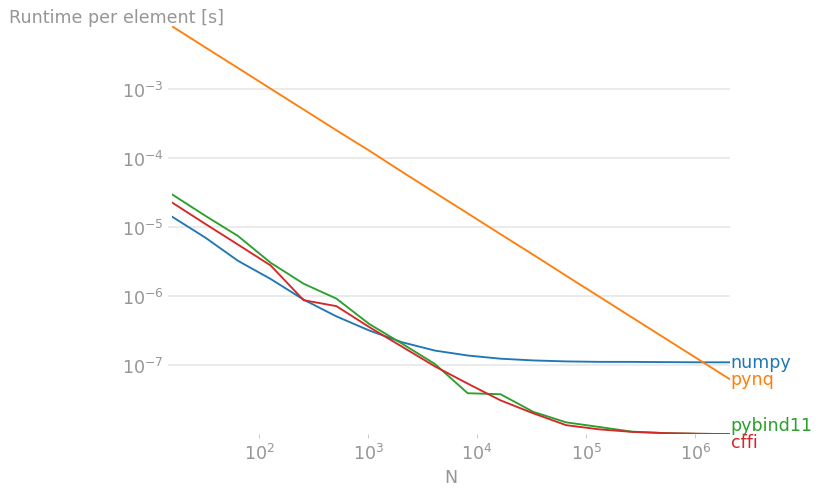

pynq_min = 1048576
pybind11_min = 1024
cffi_min = 1024
Bitstream download time = 0.21911982800000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.417974375e-05    │ 0.02177352713750… │ 0.013724787725000… │ 0.01371772716875  │
│ 32      │ 7.125346875000001… │ 0.01088238755     │ 0.006862240818750… │ 0.00685873487812… │
│ 64      │ 3.276384375000000… │ 0.00544856570781… │ 0.003431238423437… │ 0.00342937136562… │
│ 128     │ 1.78220234375e-06  │ 0.00272391771015… │ 0.001714931423437… │ 0.00171466933593… │
│ 256     │ 8.97753515625e-07  │ 0.00136274689609… │ 0.000857462778906… │ 0.00085681791718… │
│ 512     │ 5.133380859375e-07 │ 0.00068177882695… │ 0.000428896621875  │ 0.00042869074453… │
│ 1024    │ 3.2085478515625e-… │ 0.00034266760605… │ 0.000214382677441… │ 0.00021434390078… │
│ 2048    │ 2.16812353515625e… │ 0.00017049946337… │ 0.000107199026318… │ 0.00010717909155… │
│ 4096    │ 1.642404541015625… │ 8.52335508789062… │ 5.360123242187500… │ 5.35930301269531… │
│ 8192    │ 1.394038085937500… │ 4.26523392822265… │ 2.678766829833984… │ 2.68026135375976… │
│ 16384   │ 1.252901794433593… │ 2.13229869506835… │ 1.341237167358398… │ 1.34052643981933… │
│ 32768   │ 1.182843414306640… │ 1.06873389556884… │ 6.708285092163086… │ 6.70728382263183… │
│ 65536   │ 1.145082809448242… │ 5.33054944458007… │ 3.358528700256347… │ 3.35717099304199… │
│ 131072  │ 1.128143287658691… │ 2.66679970245361… │ 1.684638066864013… │ 1.68365203170776… │
│ 262144  │ 1.126789268493652… │ 1.33395050582885… │ 8.469077373504639… │ 8.46810374450683… │
│ 524288  │ 1.118278289794921… │ 6.67189689254760… │ 4.284401027679443… │ 4.28417550849914… │
│ 1048576 │ 1.112005388259887… │ 3.33867332553863… │ 2.192210931777954… │ 2.19243598365783… │
│ 2097152 │ 1.110777149200439… │ 1.67134821748733… │ 1.146428603649139… │ 1.14620281171798… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

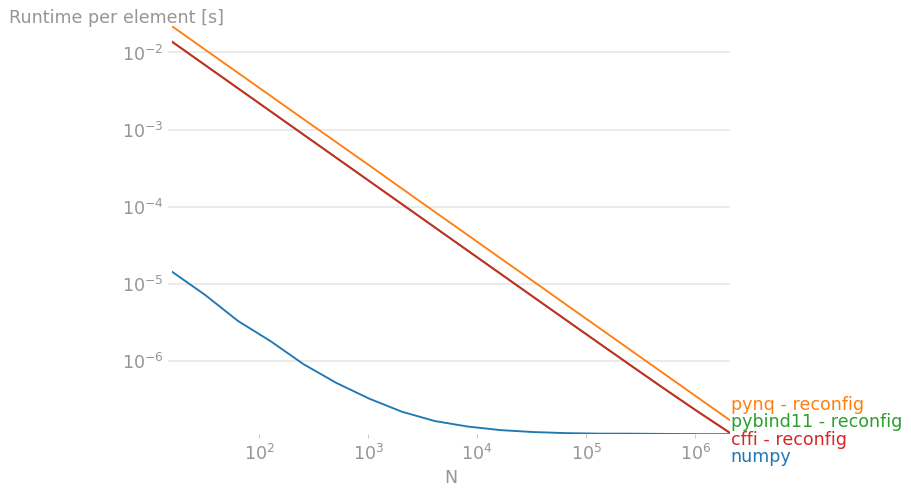

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [11]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n,), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [subtract_reduce_all_f4_numpy, subtract_reduce_all_f4_pynq, subtract_reduce_all_f4_pybind11, subtract_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## multiply_reduce_all_f4


kernel = numpy, n = 16, t = 0.00021139320000000003
kernel = pynq, n = 16, t = 0.1321820111
kernel = pybind11, n = 16, t = 0.0003670747
kernel = cffi, n = 16, t = 0.00026839470000000005
kernel = numpy, n = 32, t = 0.00021336520000000002
kernel = pynq, n = 32, t = 0.1310341181
kernel = pybind11, n = 32, t = 0.0003014341
kernel = cffi, n = 32, t = 0.0002596079
kernel = numpy, n = 64, t = 0.0002276363
kernel = pynq, n = 64, t = 0.1314313567
kernel = pybind11, n = 64, t = 0.0002998849
kernel = cffi, n = 64, t = 0.000259471
kernel = numpy, n = 128, t = 0.0002481203
kernel = pynq, n = 128, t = 0.1311595711
kernel = pybind11, n = 128, t = 0.00037591590000000003
kernel = cffi, n = 128, t = 0.0002740571
kernel = numpy, n = 256, t = 0.0002322415
kernel = pynq, n = 256, t = 0.1316836946
kernel = pybind11, n = 256, t = 0.00037452920000000003
kernel = cffi, n = 256, t = 0.0002661954
kernel = numpy, n = 512, t = 0.00027481200000000004
kernel = pynq, n = 512, t = 0.13172960220000002
kernel = pybind11,

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.321207500000000… │ 0.00826137569375  │ 2.294216875e-05    │ 1.67746687500000… │
│ 32      │ 6.667662500000000… │ 0.004094816190625 │ 9.419815625e-06    │ 8.112746875e-06   │
│ 64      │ 3.5568171875e-06   │ 0.00205361494843… │ 4.6857015625e-06   │ 4.054234375e-06   │
│ 128     │ 1.93843984375e-06  │ 0.00102468414921… │ 2.936842968750000… │ 2.14107109375e-06 │
│ 256     │ 9.07193359375e-07  │ 0.00051438943203… │ 1.463004687500000… │ 1.03982578125e-06 │
│ 512     │ 5.367421875000001… │ 0.00025728437929… │ 2.721333984375e-07 │ 5.20773828125e-07 │
│ 1024    │ 3.297689453125000… │ 0.00013065089101… │ 3.6824638671875e-… │ 2.6669169921875e… │
│ 2048    │ 2.17452783203125e… │ 6.41359360351562… │ 1.9136669921875e-… │ 1.42226416015625… │
│ 4096    │ 1.63754296875e-07  │ 3.21987588867187… │ 9.889721679687501… │ 7.52713378906250… │
│ 8192    │ 1.391799072265625… │ 1.60984693359375… │ 4.586651611328125… │ 4.08756713867187… │
│ 16384   │ 1.254497253417969… │ 8.02848175048828… │ 3.159183349609375… │ 2.52330993652343… │
│ 32768   │ 1.183167510986328… │ 4.02640950927734… │ 1.793761901855469… │ 1.74065765380859… │
│ 65536   │ 1.145500762939453… │ 2.01553702697753… │ 1.353522796630859… │ 1.30373214721679… │
│ 131072  │ 1.129113975524902… │ 1.00440592422485… │ 1.189069213867187… │ 1.10423576354980… │
│ 262144  │ 1.128178768157959… │ 5.05560739898681… │ 1.060673294067382… │ 1.05471710205078… │
│ 524288  │ 1.117655807495117… │ 2.52150985908508… │ 1.029487247467041… │ 1.02635749816894… │
│ 1048576 │ 1.112206184387207… │ 1.26524577617645… │ 1.014429225921631… │ 1.02258456230163… │
│ 2097152 │ 1.110863270282745… │ 6.35267789363861… │ 1.007915000915527… │ 1.00865993499755… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

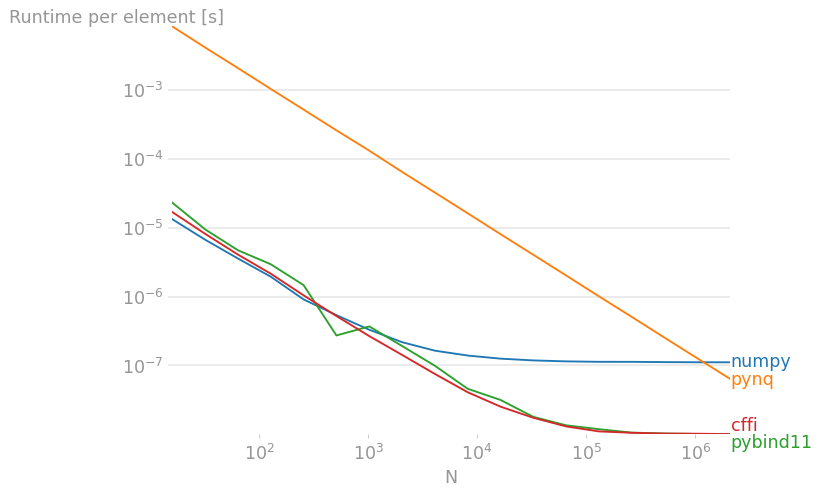

pynq_min = 1048576
pybind11_min = 1024
cffi_min = 256
Bitstream download time = 0.217160227


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.321207500000000… │ 0.02183388988125  │ 0.01359545635625   │ 0.01358928885625… │
│ 32      │ 6.667662500000000… │ 0.010881073284375 │ 0.006795676909375  │ 0.006794369840625 │
│ 64      │ 3.5568171875e-06   │ 0.00544674349531… │ 0.0033978142484375 │ 0.00339718278125… │
│ 128     │ 1.93843984375e-06  │ 0.00272124842265… │ 0.001699501116406… │ 0.00169870534453… │
│ 256     │ 9.07193359375e-07  │ 0.00136267156875  │ 0.000849745141406… │ 0.0008493219625   │
│ 512     │ 5.367421875000001… │ 0.00068142544765… │ 0.000424413201757… │ 0.00042466184218… │
│ 1024    │ 3.297689453125000… │ 0.00034272142519… │ 0.000212438780566… │ 0.00021233722587… │
│ 2048    │ 2.17452783203125e… │ 0.000170171203125 │ 0.000106226633789… │ 0.00010617749350… │
│ 4096    │ 1.63754296875e-07  │ 8.52163924316406… │ 5.311653076171875… │ 5.30929048828125… │
│ 8192    │ 1.391799072265625… │ 4.26072861083984… │ 2.655468328857422… │ 2.65496924438476… │
│ 16384   │ 1.254497253417969… │ 2.12828901367187… │ 1.328600021972656… │ 1.32796414855957… │
│ 32768   │ 1.183167510986328… │ 1.06536137023925… │ 6.645141812133789… │ 6.64461076965332… │
│ 65536   │ 1.145500762939453… │ 5.32913912353515… │ 3.327137324523926… │ 3.32663941802978… │
│ 131072  │ 1.129113975524902… │ 2.66120697250366… │ 1.668691740417480… │ 1.66784340591430… │
│ 262144  │ 1.128178768157959… │ 1.33396126403808… │ 8.390072570800782… │ 8.38947695159912… │
│ 524288  │ 1.117655807495117… │ 6.66351247978210… │ 4.244951345443725… │ 4.24463837051391… │
│ 1048576 │ 1.112206184387207… │ 3.33624708652496… │ 2.172444232940674… │ 2.17325976657867… │
│ 2097152 │ 1.110863270282745… │ 1.67076844453811… │ 1.136292155265808… │ 1.13636664867401… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

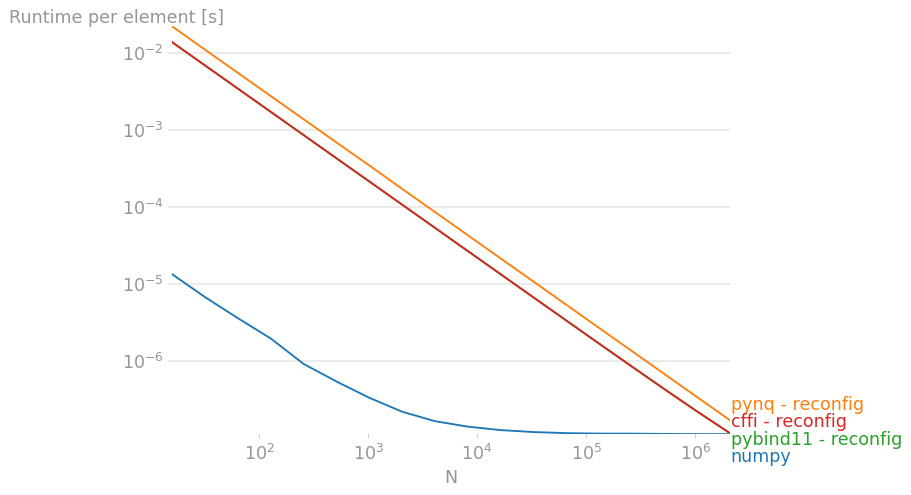

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [12]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [multiply_reduce_all_f4_numpy, multiply_reduce_all_f4_pynq, multiply_reduce_all_f4_pybind11, multiply_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## true_divide_reduce_all_f4


kernel = numpy, n = 16, t = 0.000213785


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


kernel = pynq, n = 16, t = 0.1333714057
kernel = pybind11, n = 16, t = 0.0006451653000000001
kernel = cffi, n = 16, t = 0.0004190705
kernel = numpy, n = 32, t = 0.0002103219


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


kernel = pynq, n = 32, t = 0.131997046
kernel = pybind11, n = 32, t = 0.0003873363
kernel = cffi, n = 32, t = 0.0003551038
kernel = numpy, n = 64, t = 0.00020572070000000002
kernel = pynq, n = 64, t = 0.131418101
kernel = pybind11, n = 64, t = 0.0003879173
kernel = cffi, n = 64, t = 0.0003548421
kernel = numpy, n = 128, t = 0.0003125366


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in reduce
  # This is added back by InteractiveShellApp.init_path()


kernel = pynq, n = 128, t = 0.1326086549
kernel = pybind11, n = 128, t = 0.00044770190000000004
kernel = cffi, n = 128, t = 0.0004059471
kernel = numpy, n = 256, t = 0.00026817109999999997
kernel = pynq, n = 256, t = 0.1320484265
kernel = pybind11, n = 256, t = 0.0004525643
kernel = cffi, n = 256, t = 0.0004043683
kernel = numpy, n = 512, t = 0.00030775470000000006
kernel = pynq, n = 512, t = 0.13245164680000002
kernel = pybind11, n = 512, t = 0.0005395655
kernel = cffi, n = 512, t = 0.00041668390000000003
kernel = numpy, n = 1024, t = 0.000368896
kernel = pynq, n = 1024, t = 0.13234320130000002
kernel = pybind11, n = 1024, t = 0.00044998620000000005
kernel = cffi, n = 1024, t = 0.00042974530000000003
kernel = numpy, n = 2048, t = 0.0004901733
kernel = pynq, n = 2048, t = 0.1320438413
kernel = pybind11, n = 2048, t = 0.0004575086
kernel = cffi, n = 2048, t = 0.00043686530000000003
kernel = numpy, n = 4096, t = 0.0007206456
kernel = pynq, n = 4096, t = 0.132537251
kernel = pybind11, n =

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.33615625e-05     │ 0.00833571285625  │ 4.032283125000000… │ 2.619190625e-05   │
│ 32      │ 6.572559375e-06    │ 0.0041249076875   │ 1.2104259375e-05   │ 1.109699375e-05   │
│ 64      │ 3.214385937500000… │ 0.002053407828125 │ 6.0612078125e-06   │ 5.5444078125e-06  │
│ 128     │ 2.4416921875e-06   │ 0.00103600511640… │ 3.497671093750000… │ 3.17146171875e-06 │
│ 256     │ 1.047543359374999… │ 0.00051581416601… │ 1.767829296875e-06 │ 1.579563671875e-… │
│ 512     │ 6.010833984375001… │ 0.00025869462265… │ 1.0538388671875e-… │ 8.13835742187500… │
│ 1024    │ 3.6025e-07         │ 0.00012924140751… │ 4.394396484375000… │ 4.19673144531250… │
│ 2048    │ 2.39342431640625e… │ 6.44745318847656… │ 2.2339287109375e-… │ 2.13313134765625… │
│ 4096    │ 1.759388671875e-07 │ 3.23577272949218… │ 1.167744384765625… │ 1.11534887695312… │
│ 8192    │ 1.443043457031250… │ 1.62032918945312… │ 6.210693359375e-08 │ 5.868798828125e-… │
│ 16384   │ 1.267048950195312… │ 8.10678777465820… │ 3.557324829101562… │ 3.41499206542968… │
│ 32768   │ 1.215166320800781… │ 4.02329841003417… │ 2.25841064453125e… │ 2.138505859375e-… │
│ 65536   │ 1.154710021972656… │ 2.01721311798095… │ 1.714277038574219… │ 1.53395050048828… │
│ 131072  │ 1.134666511535644… │ 1.01439607925415… │ 1.301650772094726… │ 1.22241264343261… │
│ 262144  │ 1.128550151824951… │ 5.05172226333618… │ 1.117579421997070… │ 1.11303531646728… │
│ 524288  │ 1.118958469390869… │ 2.53019587326049… │ 1.056960601806640… │ 1.05518447875976… │
│ 1048576 │ 1.112419065475464… │ 1.27033417224884… │ 1.028664894104003… │ 1.03135056495666… │
│ 2097152 │ 1.110751374721527… │ 6.37716706275939… │ 1.016028108596801… │ 1.01698582172393… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

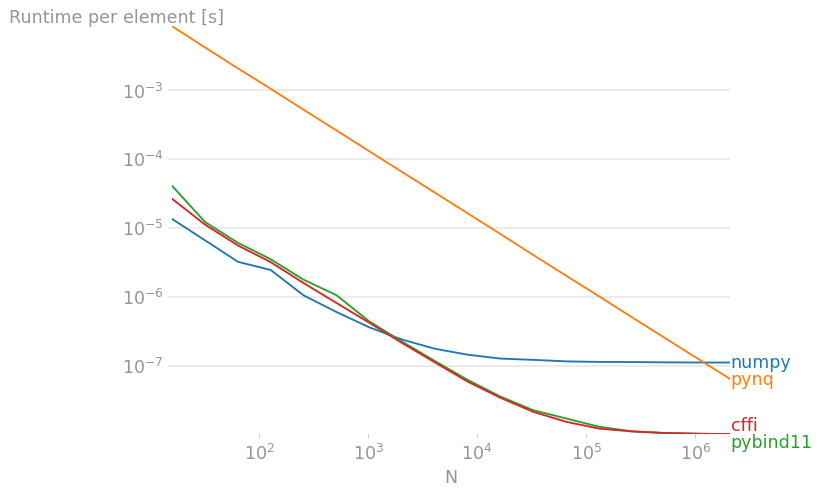

pynq_min = 1048576
pybind11_min = 1024
cffi_min = 1024
Bitstream download time = 0.218930277


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.33615625e-05     │ 0.02201885516875  │ 0.01372346514375   │ 0.01370933421875  │
│ 32      │ 6.572559375e-06    │ 0.01096647884375  │ 0.006853675415625… │ 0.00685266815     │
│ 64      │ 3.214385937500000… │ 0.00547419340625  │ 0.003426846785937… │ 0.00342632998593… │
│ 128     │ 2.4416921875e-06   │ 0.00274639790546… │ 0.001713890460156… │ 0.00171356425078… │
│ 256     │ 1.047543359374999… │ 0.00137101056054… │ 0.000856964223828… │ 0.00085677595820… │
│ 512     │ 6.010833984375001… │ 0.00068629281992… │ 0.000428652036132… │ 0.00042841203300… │
│ 1024    │ 3.6025e-07         │ 0.00034304050615… │ 0.000214238538281… │ 0.00021421877177… │
│ 2048    │ 2.39342431640625e… │ 0.00017137408120… │ 0.0001071229421875 │ 0.00010711286245… │
│ 4096    │ 1.759388671875e-07 │ 8.58075019531250… │ 5.356654909667969… │ 5.35613095458984… │
│ 8192    │ 1.443043457031250… │ 4.29281792236328… │ 2.678699426269531… │ 2.67835753173828… │
│ 16384   │ 1.267048950195312… │ 2.14692314392089… │ 1.339801691284179… │ 1.33965935852050… │
│ 32768   │ 1.215166320800781… │ 1.07045202423095… │ 6.703805938720703… │ 6.70260689086914… │
│ 65536   │ 1.154710021972656… │ 5.35782403411865… │ 3.357753686523437… │ 3.35595042114257… │
│ 131072  │ 1.134666511535644… │ 2.68470153732299… │ 1.683321965789795… │ 1.68252958450317… │
│ 262144  │ 1.128550151824951… │ 1.34032495536804… │ 8.463285232543946… │ 8.46283082199096… │
│ 524288  │ 1.118958469390869… │ 6.70595951843261… │ 4.281459705352783… │ 4.28128209304809… │
│ 1048576 │ 1.112419065475464… │ 3.35821599483490… │ 2.19074831199646e… │ 2.19101687908172… │
│ 2097152 │ 1.110751374721527… │ 1.68165761756896… │ 1.14554372215271e… │ 1.14563949346542… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

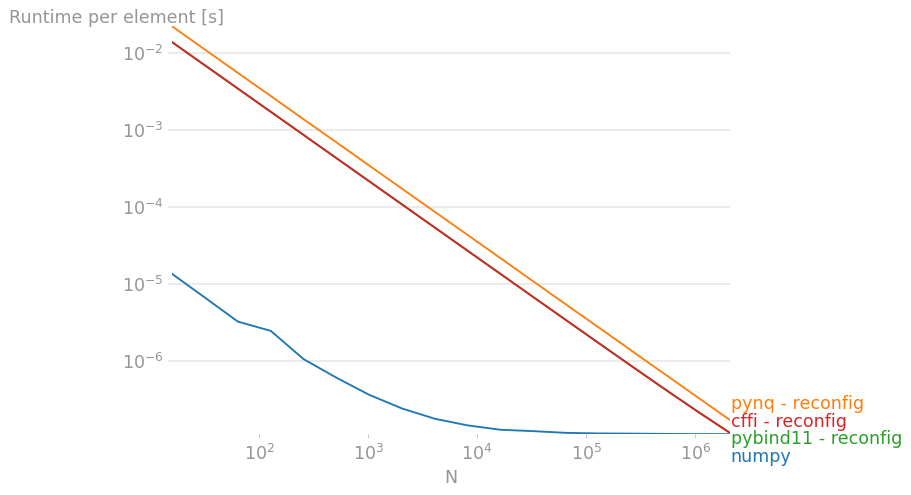

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [13]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [true_divide_reduce_all_f4_numpy, true_divide_reduce_all_f4_pynq, true_divide_reduce_all_f4_pybind11, true_divide_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## logaddexp_reduce_all_f4


kernel = numpy, n = 16, t = 0.0002501011
kernel = pynq, n = 16, t = 0.1313439083
kernel = pybind11, n = 16, t = 0.0003813276
kernel = cffi, n = 16, t = 0.00026692740000000006
kernel = numpy, n = 32, t = 0.0002143221
kernel = pynq, n = 32, t = 0.1315059183
kernel = pybind11, n = 32, t = 0.00030276340000000003
kernel = cffi, n = 32, t = 0.000263656
kernel = numpy, n = 64, t = 0.0002298439
kernel = pynq, n = 64, t = 0.1316538807
kernel = pybind11, n = 64, t = 0.00038058670000000005
kernel = cffi, n = 64, t = 0.00026196250000000003
kernel = numpy, n = 128, t = 0.0002786255
kernel = pynq, n = 128, t = 0.1320793641
kernel = pybind11, n = 128, t = 0.0003709776
kernel = cffi, n = 128, t = 0.0002702452
kernel = numpy, n = 256, t = 0.00032271750000000004
kernel = pynq, n = 256, t = 0.13179540320000002
kernel = pybind11, n = 256, t = 0.00030581290000000007
kernel = cffi, n = 256, t = 0.00026469359999999997
kernel = numpy, n = 512, t = 0.0004441721
kernel = pynq, n = 512, t = 0.13214419900000002
k

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.563131875e-05    │ 0.00820899426875  │ 2.3832975e-05      │ 1.66829625000000… │
│ 32      │ 6.697565625e-06    │ 0.004109559946875 │ 9.461356250000001… │ 8.23925e-06       │
│ 64      │ 3.5913109375e-06   │ 0.00205709188593… │ 5.946667187500001… │ 4.09316406250000… │
│ 128     │ 2.17676171875e-06  │ 0.00103187003203… │ 2.8982625e-06      │ 2.111290625e-06   │
│ 256     │ 1.260615234375000… │ 0.00051482579375… │ 1.194581640625000… │ 1.03395937499999… │
│ 512     │ 8.675236328125e-07 │ 0.00025809413867… │ 7.419984375e-07    │ 5.24012109375000… │
│ 1024    │ 6.649437500000001… │ 0.00012950234863… │ 2.927244140625e-07 │ 2.65455468750000… │
│ 2048    │ 5.461240722656251… │ 6.44210258789062… │ 1.512190429687499… │ 1.36810400390625… │
│ 4096    │ 5.03031787109375e… │ 3.23758796875e-05 │ 1.005646728515625… │ 7.333759765625e-… │
│ 8192    │ 4.723858154296875… │ 1.61448182128906… │ 5.416607666015625… │ 4.21129272460937… │
│ 16384   │ 4.617424865722657… │ 8.06855022583007… │ 3.261170654296875… │ 2.39271118164062… │
│ 32768   │ 4.5116181640625e-… │ 4.04920895080566… │ 2.060525207519531… │ 1.70899475097656… │
│ 65536   │ 4.492196929931641… │ 2.02522658233642… │ 1.473570861816406… │ 1.30013519287109… │
│ 131072  │ 4.459537368774415… │ 1.01062433853149… │ 1.120694198608398… │ 1.10238510131835… │
│ 262144  │ 4.449964218139648… │ 5.08461605453491… │ 1.059255256652832… │ 1.05424133300781… │
│ 524288  │ 4.439633371353149… │ 2.53530010795593… │ 1.029798889160156… │ 1.02769052505493… │
│ 1048576 │ 4.435817667961121… │ 1.26806828498840… │ 1.015123357772827… │ 1.02145079612731… │
│ 2097152 │ 4.447159019947052… │ 6.35144696235656… │ 1.007710747718811… │ 1.00799560546875… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

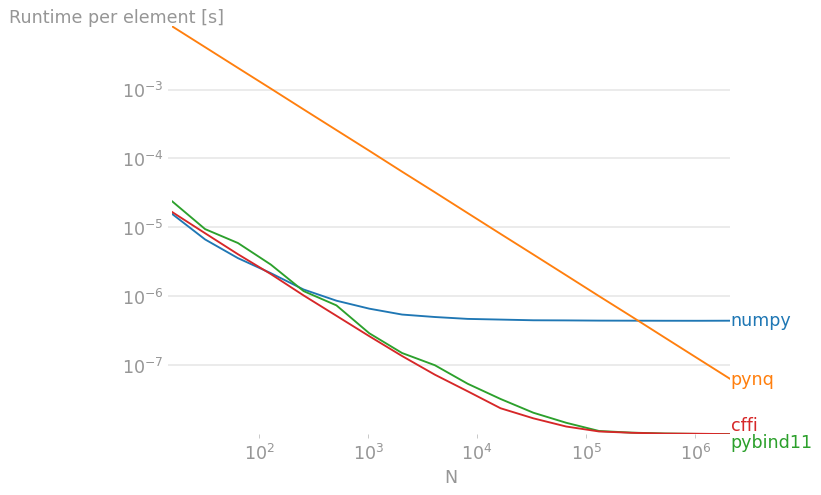

pynq_min = 262144
pybind11_min = 128
cffi_min = 64
Bitstream download time = 0.22118289200000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.563131875e-05    │ 0.02203292501875… │ 0.013847763725000… │ 0.01384061371250… │
│ 32      │ 6.697565625e-06    │ 0.011021525321875 │ 0.00692142673125   │ 0.00692020462500… │
│ 64      │ 3.5913109375e-06   │ 0.00551307457343… │ 0.0034619293546875 │ 0.00346007585156… │
│ 128     │ 2.17676171875e-06  │ 0.00275986137578… │ 0.00173088960625   │ 0.001730102634375 │
│ 256     │ 1.260615234375000… │ 0.001378821465625 │ 0.000865190253515… │ 0.00086502963125… │
│ 512     │ 8.675236328125e-07 │ 0.00069009197460… │ 0.000432739834375… │ 0.00043252184804… │
│ 1024    │ 6.649437500000001… │ 0.00034550126660… │ 0.000216291642382… │ 0.00021626437343… │
│ 2048    │ 5.461240722656251… │ 0.00017242048486… │ 0.000108150678027… │ 0.00010813626938… │
│ 4096    │ 5.03031787109375e… │ 8.63756091796875… │ 5.410029416503907… │ 5.40730670898437… │
│ 8192    │ 4.723858154296875… │ 4.31446829589843… │ 2.705403082275390… │ 2.70419776733398… │
│ 16384   │ 4.617424865722657… │ 2.15684825988769… │ 1.353254407958984… │ 1.35238594848632… │
│ 32768   │ 4.5116181640625e-… │ 1.07991751373291… │ 6.770571438598634… │ 6.76705613403320… │
│ 65536   │ 4.492196929931641… │ 5.40020967559814… │ 3.389718801879883… │ 3.38798444519043… │
│ 131072  │ 4.459537368774415… │ 2.69811588516235… │ 1.698698488616943… │ 1.69851539764404… │
│ 262144  │ 4.449964218139648… │ 1.35220737876892… │ 8.54338325881958e… │ 8.54288186645507… │
│ 524288  │ 4.439633371353149… │ 6.75402897453308… │ 4.321708755493164… │ 4.32149791908264… │
│ 1048576 │ 4.435817667961121… │ 3.37743271827697… │ 2.210876769065857… │ 2.21150951290130… │
│ 2097152 │ 4.447159019947052… │ 1.68982691287994… │ 1.155453291416168… │ 1.15548177719116… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

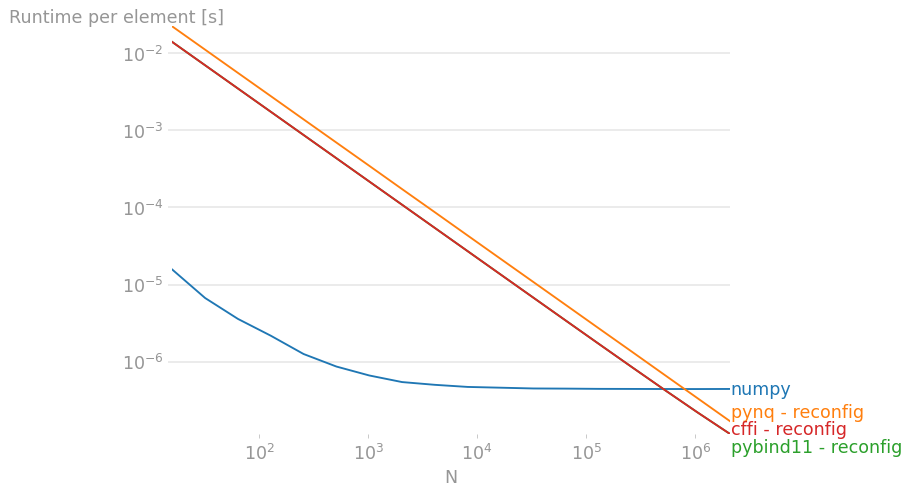

pynq_min_reconf = 524288
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [14]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [logaddexp_reduce_all_f4_numpy, logaddexp_reduce_all_f4_pynq, logaddexp_reduce_all_f4_pybind11, logaddexp_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## logaddexp2_reduce_all_f4


kernel = numpy, n = 16, t = 0.00020714460000000002
kernel = pynq, n = 16, t = 0.13196014650000001
kernel = pybind11, n = 16, t = 0.0003510298
kernel = cffi, n = 16, t = 0.0003165911
kernel = numpy, n = 32, t = 0.0002207846
kernel = pynq, n = 32, t = 0.1310614118
kernel = pybind11, n = 32, t = 0.00042433970000000005
kernel = cffi, n = 32, t = 0.00032751190000000004
kernel = numpy, n = 64, t = 0.00022652860000000003
kernel = pynq, n = 64, t = 0.1313662608
kernel = pybind11, n = 64, t = 0.00034172470000000003
kernel = cffi, n = 64, t = 0.0003231006
kernel = numpy, n = 128, t = 0.00026699300000000004
kernel = pynq, n = 128, t = 0.13159813580000002
kernel = pybind11, n = 128, t = 0.0003428761
kernel = cffi, n = 128, t = 0.0003208853
kernel = numpy, n = 256, t = 0.0003108273
kernel = pynq, n = 256, t = 0.13121731050000002
kernel = pybind11, n = 256, t = 0.00042619900000000004
kernel = cffi, n = 256, t = 0.0003204873
kernel = numpy, n = 512, t = 0.00043971590000000006
kernel = pynq, n = 512, 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.294653750000000… │ 0.00824750915625… │ 2.19393625e-05     │ 1.978694375e-05   │
│ 32      │ 6.89951875e-06     │ 0.00409566911875  │ 1.326061562500000… │ 1.02347468750000… │
│ 64      │ 3.539509375000000… │ 0.002052597825    │ 5.339448437500000… │ 5.048446875e-06   │
│ 128     │ 2.085882812500000… │ 0.00102811043593… │ 2.67871953125e-06  │ 2.50691640625e-06 │
│ 256     │ 1.214169140625e-06 │ 0.00051256761914… │ 1.664839843750000… │ 1.251903515625e-… │
│ 512     │ 8.588201171875001… │ 0.00025696384628… │ 8.657035156250001… │ 6.23475390625000… │
│ 1024    │ 6.404768554687501… │ 0.00012859806894… │ 4.311255859375e-07 │ 3.167427734375e-… │
│ 2048    │ 5.474951660156251… │ 6.4365580859375e… │ 1.769724609375e-07 │ 1.61050000000000… │
│ 4096    │ 4.959188720703126… │ 3.22289049316406… │ 9.338159179687501… │ 8.57871826171875… │
│ 8192    │ 4.717264160156250… │ 1.61007744262695… │ 3.260333251953125… │ 4.69984985351562… │
│ 16384   │ 4.587136535644531… │ 8.05936491699218… │ 2.988168334960938… │ 2.89772521972656… │
│ 32768   │ 4.508789916992188… │ 4.02649007873535… │ 1.976862182617187… │ 1.85742034912109… │
│ 65536   │ 4.491135238647461… │ 2.01493936920166… │ 1.434869842529297… │ 1.39642944335937… │
│ 131072  │ 4.462979751586914… │ 1.01072440643310… │ 1.157058715820312… │ 1.15843978881835… │
│ 262144  │ 4.450892147064209… │ 5.04842728805542… │ 1.081122970581054… │ 1.07735393524169… │
│ 524288  │ 4.443968263626099… │ 2.52518298339843… │ 1.040352630615234… │ 1.03819046020507… │
│ 1048576 │ 4.43682873916626e… │ 1.26404846000671… │ 1.020497894287109… │ 1.02177067756652… │
│ 2097152 │ 4.435521009445191… │ 6.35375334739685… │ 1.010736894607544… │ 1.01090306758880… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

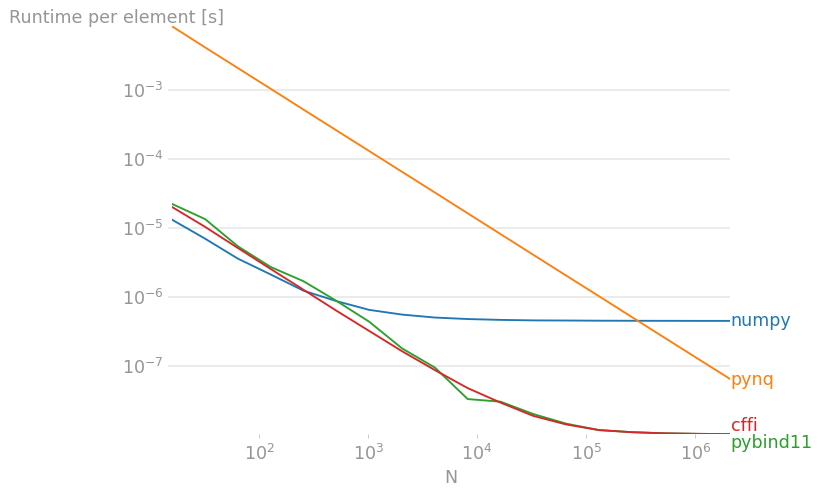

pynq_min = 262144
pybind11_min = 512
cffi_min = 256
Bitstream download time = 0.21679065500000003


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.294653750000000… │ 0.02179692509375… │ 0.013571355300000… │ 0.01356920288125… │
│ 32      │ 6.89951875e-06     │ 0.0108703770875   │ 0.006787968584375… │ 0.00678494271562… │
│ 64      │ 3.539509375000000… │ 0.005439951809375 │ 0.003392693432812… │ 0.00339240243125  │
│ 128     │ 2.085882812500000… │ 0.00272178742812… │ 0.001696355711718… │ 0.00169618390859… │
│ 256     │ 1.214169140625e-06 │ 0.00135940611523… │ 0.000848503335937… │ 0.00084809039960… │
│ 512     │ 8.588201171875001… │ 0.00068038309433… │ 0.000424284951562… │ 0.00042404272343… │
│ 1024    │ 6.404768554687501… │ 0.00034030769296… │ 0.000212140749609… │ 0.00021202636679… │
│ 2048    │ 5.474951660156251… │ 0.00017022039287… │ 0.000106031784472… │ 0.00010601586201… │
│ 4096    │ 4.959188720703126… │ 8.51563109375e-05 │ 5.302078759765626… │ 5.30131931884765… │
│ 8192    │ 4.717264160156250… │ 4.25644774291992… │ 2.649630633544922… │ 2.65107015014648… │
│ 16384   │ 4.587136535644531… │ 2.12912164184570… │ 1.326173318481445… │ 1.32608287536621… │
│ 32768   │ 4.508789916992188… │ 1.06424158294677… │ 6.635694372558595… │ 6.63449995422363… │
│ 65536   │ 4.491135238647461… │ 5.32290224456787… │ 3.322311573791504… │ 3.32192716979980… │
│ 131072  │ 4.462979751586914… │ 2.66470584411621… │ 1.665552024841308… │ 1.66556583557128… │
│ 262144  │ 4.450892147064209… │ 1.33183344764709… │ 8.378019485473634… │ 8.37764258193969… │
│ 524288  │ 4.443968263626099… │ 6.66013657760620… │ 4.238988857269287… │ 4.23877264022827… │
│ 1048576 │ 4.43682873916626e… │ 3.33152525711059… │ 2.169526586532593… │ 2.16965386486053… │
│ 2097152 │ 4.435521009445191… │ 1.66911373329162… │ 1.134812088012695… │ 1.13482870531082… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

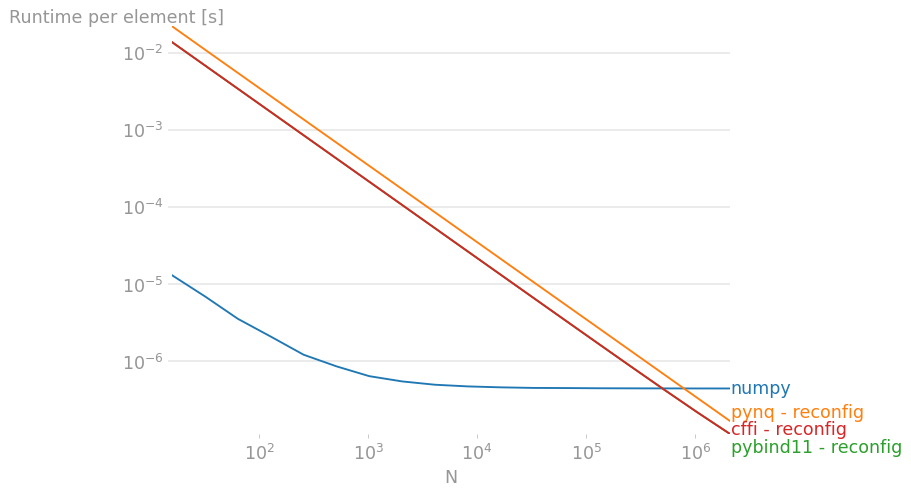

pynq_min_reconf = 524288
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [15]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [logaddexp2_reduce_all_f4_numpy, logaddexp2_reduce_all_f4_pynq, logaddexp2_reduce_all_f4_pybind11, logaddexp2_reduce_all_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## dot_f4


kernel = numpy, n = 16, t = 0.00018151540000000001
kernel = pynq, n = 16, t = 0.1574184336
kernel = pybind11, n = 16, t = 0.0003764253
kernel = cffi, n = 16, t = 0.00026766750000000003
kernel = numpy, n = 32, t = 0.00019454710000000003
kernel = pynq, n = 32, t = 0.1565734997
kernel = pybind11, n = 32, t = 0.0003785486
kernel = cffi, n = 32, t = 0.0002750101
kernel = numpy, n = 64, t = 0.00019145110000000001
kernel = pynq, n = 64, t = 0.1593522705
kernel = pybind11, n = 64, t = 0.00037972580000000003
kernel = cffi, n = 64, t = 0.00026936800000000003
kernel = numpy, n = 128, t = 0.0002056012
kernel = pynq, n = 128, t = 0.1642873477
kernel = pybind11, n = 128, t = 0.00037925780000000003
kernel = cffi, n = 128, t = 0.0003038858
kernel = numpy, n = 256, t = 0.0002561252
kernel = pynq, n = 256, t = 0.15890606380000002
kernel = pybind11, n = 256, t = 0.0002997065
kernel = cffi, n = 256, t = 0.0002820133
kernel = numpy, n = 512, t = 0.00029274890000000005
kernel = pynq, n = 512, t = 0.15740301

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.134471250000000… │ 0.0098386521      │ 2.352658125e-05    │ 1.67292187500000… │
│ 32      │ 6.079596875000001… │ 0.004892921865625 │ 1.182964375e-05    │ 8.594065625e-06   │
│ 64      │ 2.991423437500000… │ 0.00248987922656… │ 5.933215625000000… │ 4.20887500000000… │
│ 128     │ 1.606259375e-06    │ 0.00128349490390… │ 2.962951562500000… │ 2.3741078125e-06  │
│ 256     │ 1.0004890625e-06   │ 0.00062072681171… │ 1.170728515625e-06 │ 1.101614453125e-… │
│ 512     │ 5.717751953125001… │ 0.00030742776816… │ 7.635199218750001… │ 5.398912109375e-… │
│ 1024    │ 4.0806650390625e-… │ 0.00015325358955… │ 3.003290039062500… │ 2.7948466796875e… │
│ 2048    │ 3.14507470703125e… │ 7.6709377734375e… │ 1.547527343749999… │ 1.45838037109375… │
│ 4096    │ 3.243344482421875… │ 3.83756302001953… │ 8.83353271484375e… │ 7.56708251953125… │
│ 8192    │ 2.999625122070312… │ 1.92917153076171… │ 3.43532470703125e… │ 4.20411987304687… │
│ 16384   │ 2.900257873535156… │ 9.59671088867187… │ 3.250578613281251… │ 2.60281188964843… │
│ 32768   │ 2.838045074462891… │ 4.79449719543457… │ 2.135458679199219… │ 1.747412109375e-… │
│ 65536   │ 2.826252212524414… │ 2.40157216491699… │ 1.506730499267578… │ 1.32696533203125… │
│ 131072  │ 2.798897087097168… │ 1.20293262481689… │ 1.137055435180664… │ 1.11318176269531… │
│ 262144  │ 2.783346328735352… │ 6.03977054595947… │ 1.057771492004394… │ 1.05440750122070… │
│ 524288  │ 2.774643886566162… │ 3.01789850425720… │ 1.031147956848144… │ 1.02991474151611… │
│ 1048576 │ 2.770800885200500… │ 1.51754660129547… │ 1.014947128295898… │ 1.02578042030334… │
│ 2097152 │ 2.771062896728516… │ 7.65809202671051… │ 1.007815475463867… │ 1.00826832294464… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

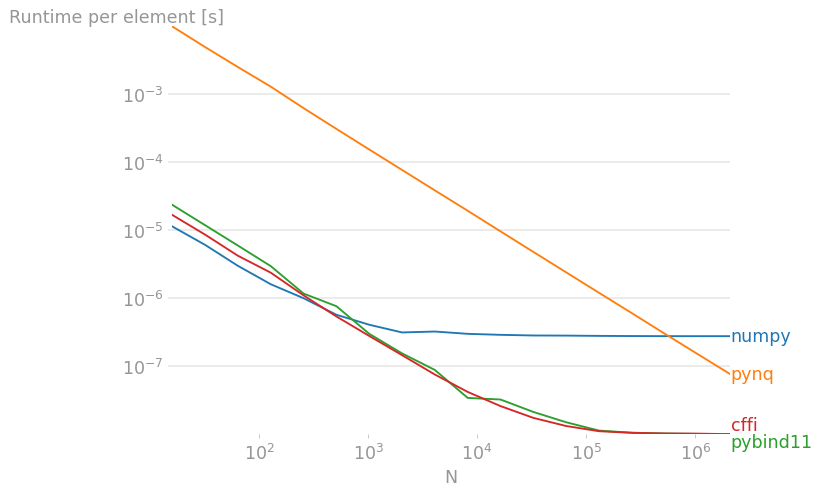

pynq_min = 524288
pybind11_min = 512
cffi_min = 256
Bitstream download time = 0.215192984


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 1.134471250000000… │ 0.0232882136      │ 0.013473088081250… │ 0.01346629071875… │
│ 32      │ 6.079596875000001… │ 0.011617702615625 │ 0.00673661039375   │ 0.006733374815625 │
│ 64      │ 2.991423437500000… │ 0.00585226960156… │ 0.003368323590625  │ 0.00336659925     │
│ 128     │ 1.606259375e-06    │ 0.00296469009140… │ 0.0016841581390625 │ 0.00168356929531… │
│ 256     │ 1.0004890625e-06   │ 0.00146132440546… │ 0.000841768322265… │ 0.00084169920820… │
│ 512     │ 5.717751953125001… │ 0.00072772656503… │ 0.000421062316796… │ 0.00042083868808… │
│ 1024    │ 4.0806650390625e-… │ 0.00036340298798… │ 0.000210449727441… │ 0.00021042888310… │
│ 2048    │ 3.14507470703125e… │ 0.00018178407695… │ 0.000105229451953… │ 0.00010522053725… │
│ 4096    │ 3.243344482421875… │ 9.09129798095703… │ 5.262568493652344… │ 5.26130204345703… │
│ 8192    │ 2.999625122070312… │ 4.55603901123046… │ 2.630302805175781… │ 2.63107160034179… │
│ 16384   │ 2.900257873535156… │ 2.27310482910156… │ 1.316684318847656… │ 1.31603655212402… │
│ 32768   │ 2.838045074462891… │ 1.13616658966064… │ 6.588523287963867… │ 6.58464282226562… │
│ 65536   │ 2.826252212524414… │ 5.68515651550293… │ 3.298651655578613… │ 3.29685400390625… │
│ 131072  │ 2.798897087097168… │ 2.84472480010986… │ 1.653162729644775… │ 1.65292399291992… │
│ 262144  │ 2.783346328735352… │ 1.42487314224243… │ 8.314738025665283… │ 8.31440162658691… │
│ 524288  │ 2.774643886566162… │ 7.12237894248962… │ 4.207595233917236… │ 4.20747191238403… │
│ 1048576 │ 2.770800885200500… │ 3.56978682041168… │ 2.153734931945800… │ 2.15481826114654… │
│ 2097152 │ 2.771062896728516… │ 1.79192931222915… │ 1.126901657104492… │ 1.12694694185256… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

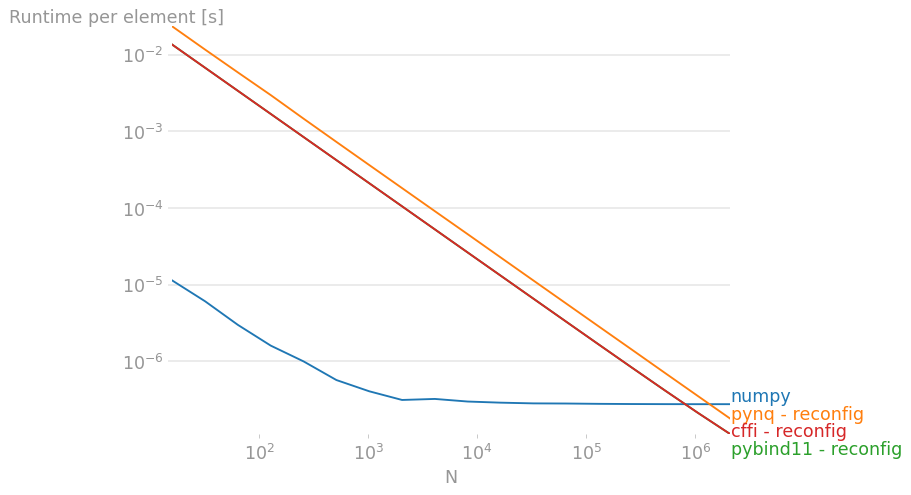

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [16]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")
    x2 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x2.shape)

    return x1, x2

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [dot_f4_numpy, dot_f4_pynq, dot_f4_pybind11, dot_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sum_of_squares_f4


kernel = numpy, n = 16, t = 0.0004919098000000001
kernel = pynq, n = 16, t = 0.1316280473
kernel = pybind11, n = 16, t = 0.00037916830000000003
kernel = cffi, n = 16, t = 0.00026392120000000004
kernel = numpy, n = 32, t = 0.0005067597000000001
kernel = pynq, n = 32, t = 0.13118234750000002
kernel = pybind11, n = 32, t = 0.00037387170000000003
kernel = cffi, n = 32, t = 0.0002614105
kernel = numpy, n = 64, t = 0.0005284059
kernel = pynq, n = 64, t = 0.132118122
kernel = pybind11, n = 64, t = 0.000290352
kernel = cffi, n = 64, t = 0.00026844659999999997
kernel = numpy, n = 128, t = 0.0005044397
kernel = pynq, n = 128, t = 0.1319298909
kernel = pybind11, n = 128, t = 0.00029262250000000004
kernel = cffi, n = 128, t = 0.0002631351
kernel = numpy, n = 256, t = 0.00051814
kernel = pynq, n = 256, t = 0.1317535792
kernel = pybind11, n = 256, t = 0.00038768920000000005
kernel = cffi, n = 256, t = 0.0002671729
kernel = numpy, n = 512, t = 0.0005750157
kernel = pynq, n = 512, t = 0.1318616229
ker

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.074436250000000… │ 0.00822675295625  │ 2.369801875000000… │ 1.64950750000000… │
│ 32      │ 1.583624062500000… │ 0.00409944835937… │ 1.168349062500000… │ 8.169078125e-06   │
│ 64      │ 8.2563421875e-06   │ 0.00206434565625  │ 4.53675e-06        │ 4.19447812499999… │
│ 128     │ 3.94093515625e-06  │ 0.00103070227265… │ 2.286113281250000… │ 2.05574296875e-06 │
│ 256     │ 2.023984375e-06    │ 0.00051466241875  │ 1.514410937500000… │ 1.043644140625e-… │
│ 512     │ 1.1230775390625e-… │ 0.00025754223222… │ 7.3905e-07         │ 5.41144335937500… │
│ 1024    │ 5.418341796875e-07 │ 0.00012880577509… │ 2.92721875e-07     │ 2.64806835937500… │
│ 2048    │ 2.88001025390625e… │ 6.44315807128906… │ 1.911653808593750… │ 1.38452197265625… │
│ 4096    │ 1.640296630859375… │ 3.22495176757812… │ 4.45510009765625e… │ 7.28083740234375… │
│ 8192    │ 1.061208251953125… │ 1.61254524658203… │ 5.709816894531250… │ 4.11415649414062… │
│ 16384   │ 7.062991943359376… │ 8.08670665893554… │ 2.691325073242187… │ 2.52405700683593… │
│ 32768   │ 5.481258239746094… │ 4.03653854980468… │ 1.793443603515625… │ 1.70243469238281… │
│ 65536   │ 4.766930236816407… │ 2.01679864807128… │ 1.483393249511718… │ 1.21290756225585… │
│ 131072  │ 5.576807327270508… │ 1.01101152725219… │ 1.182649383544921… │ 1.10744255065917… │
│ 262144  │ 5.571661148071289… │ 5.05567459869384… │ 1.059455642700195… │ 1.05454196929931… │
│ 524288  │ 5.293672885894775… │ 2.52944941902160… │ 1.029253158569336… │ 1.02737367630004… │
│ 1048576 │ 5.113942880630494… │ 1.26638685703277… │ 1.015599021911621… │ 1.02299378395080… │
│ 2097152 │ 5.043638401031494… │ 6.38592175006866… │ 1.008357844352722… │ 1.00808275699615… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

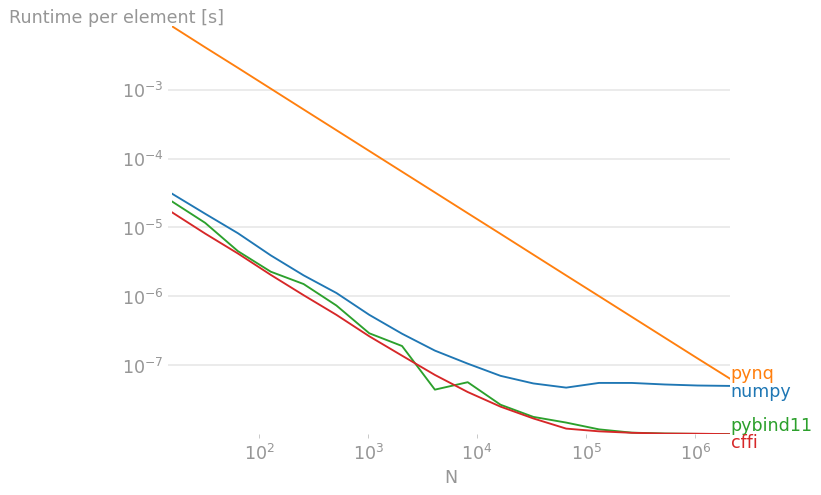

pynq_min = inf
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.21927031900000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.074436250000000… │ 0.02193114789375… │ 0.013728092956250… │ 0.0137208900125   │
│ 32      │ 1.583624062500000… │ 0.01095164582812… │ 0.006863880959375… │ 0.00686036654687… │
│ 64      │ 8.2563421875e-06   │ 0.005490444390625 │ 0.003430635484375  │ 0.00343029321250… │
│ 128     │ 3.94093515625e-06  │ 0.00274375163984… │ 0.001715335480468… │ 0.00171510511015… │
│ 256     │ 2.023984375e-06    │ 0.00137118710234… │ 0.000858039094531… │ 0.00085756832773… │
│ 512     │ 1.1230775390625e-… │ 0.00068580457402… │ 0.000429001391796… │ 0.00042880348613… │
│ 1024    │ 5.418341796875e-07 │ 0.00034293694599… │ 0.000214423892773… │ 0.00021439597773… │
│ 2048    │ 2.88001025390625e… │ 0.00017149716616… │ 0.000107256750830… │ 0.00010720403764… │
│ 4096    │ 1.640296630859375… │ 8.57823104003906… │ 5.357734372558594… │ 5.36056010986328… │
│ 8192    │ 1.061208251953125… │ 4.2891848828125e… │ 2.682349453125000… │ 2.68075379272460… │
│ 16384   │ 7.062991943359376… │ 2.14699048400878… │ 1.341011143188476… │ 1.34084387512207… │
│ 32768   │ 5.481258239746094… │ 1.07281376403808… │ 6.709533526611329… │ 6.70862343750000… │
│ 65536   │ 4.766930236816407… │ 5.36259819335937… │ 3.360633477783203… │ 3.35792862091064… │
│ 131072  │ 5.576807327270508… │ 2.68391129989624… │ 1.684726266479492… │ 1.68397419815063… │
│ 262144  │ 5.571661148071289… │ 1.34201734619140… │ 8.470444427490235… │ 8.46995306015014… │
│ 524288  │ 5.293672885894775… │ 6.71169885063171… │ 4.285174747467041… │ 4.28498679924011… │
│ 1048576 │ 5.113942880630494… │ 3.35751157283783… │ 2.192684617996216… │ 2.19342409420013… │
│ 2097152 │ 5.043638401031494… │ 1.68415453290939… │ 1.146398142337799… │ 1.14637063360214… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

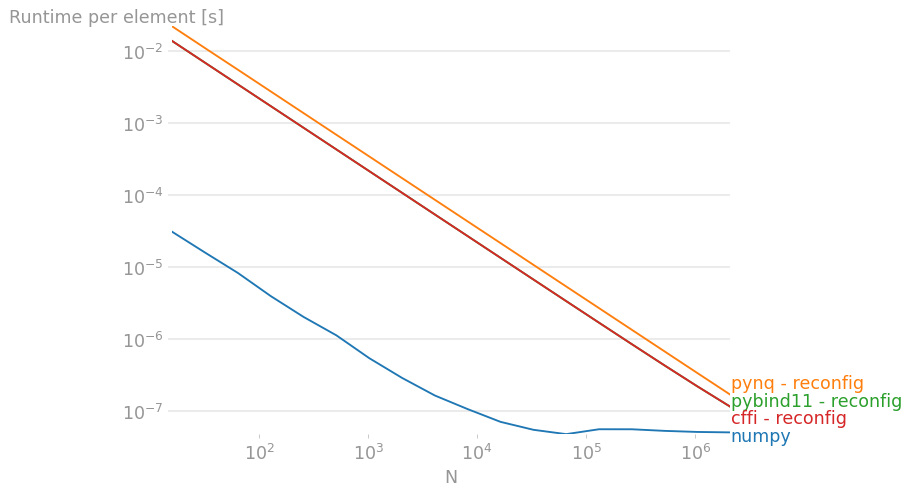

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [17]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)

    return (x1,)

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sum_of_squares_f4_numpy, sum_of_squares_f4_pynq, sum_of_squares_f4_pybind11, sum_of_squares_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sad_f4


kernel = numpy, n = 16, t = 0.0005498584000000001
kernel = pynq, n = 16, t = 0.15845717510000001
kernel = pybind11, n = 16, t = 0.0003794258
kernel = cffi, n = 16, t = 0.0002697406
kernel = numpy, n = 32, t = 0.0005588067
kernel = pynq, n = 32, t = 0.1577755166
kernel = pybind11, n = 32, t = 0.000300108
kernel = cffi, n = 32, t = 0.0002671771
kernel = numpy, n = 64, t = 0.0005634720000000001
kernel = pynq, n = 64, t = 0.15743390340000002
kernel = pybind11, n = 64, t = 0.00038051620000000003
kernel = cffi, n = 64, t = 0.0002663965
kernel = numpy, n = 128, t = 0.0005809416000000001
kernel = pynq, n = 128, t = 0.1574245792
kernel = pybind11, n = 128, t = 0.00037654590000000003
kernel = cffi, n = 128, t = 0.0002719351
kernel = numpy, n = 256, t = 0.0006685588000000001
kernel = pynq, n = 256, t = 0.15754627980000002
kernel = pybind11, n = 256, t = 0.0003009886
kernel = cffi, n = 256, t = 0.0002719483
kernel = numpy, n = 512, t = 0.0007100816
kernel = pynq, n = 512, t = 0.15765986930000003
k

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.436615000000000… │ 0.00990357344375… │ 2.37141125e-05     │ 1.68587875e-05    │
│ 32      │ 1.7462709375e-05   │ 0.00493048489375  │ 9.378375e-06       │ 8.349284375e-06   │
│ 64      │ 8.804250000000001… │ 0.00245990474062… │ 5.945565625000000… │ 4.1624453125e-06  │
│ 128     │ 4.538606250000000… │ 0.001229879525    │ 2.941764843750000… │ 2.12449296875e-06 │
│ 256     │ 2.611557812500000… │ 0.00061541515546… │ 1.17573671875e-06  │ 1.062298046875e-… │
│ 512     │ 1.386878125e-06    │ 0.00030792943222… │ 7.623052734375e-07 │ 5.33467578125000… │
│ 1024    │ 8.447609375e-07    │ 0.00015401601396… │ 3.114247070312500… │ 2.69688476562500… │
│ 2048    │ 5.40568505859375e… │ 7.69589117187499… │ 1.9209423828125e-… │ 1.41770605468750… │
│ 4096    │ 4.644403808593750… │ 3.86059940429687… │ 8.414868164062501… │ 7.52372314453125… │
│ 8192    │ 3.84836279296875e… │ 1.92752299194335… │ 5.502452392578126… │ 4.25898559570312… │
│ 16384   │ 3.517579284667969… │ 9.64067591552734… │ 3.223642578125e-08 │ 2.58187133789062… │
│ 32768   │ 3.357139709472656… │ 4.83612477722167… │ 2.111838989257812… │ 1.75504913330078… │
│ 65536   │ 3.318426788330078… │ 2.42472685546875… │ 1.506370239257812… │ 1.32560943603515… │
│ 131072  │ 3.368384300231934… │ 1.21224654693603… │ 1.133654708862304… │ 1.11431365966796… │
│ 262144  │ 3.433197799682617… │ 6.05053638458252… │ 1.059197158813476… │ 1.05461544036865… │
│ 524288  │ 3.397350605010987… │ 3.03089627838134… │ 1.029283599853515… │ 1.02747955322265… │
│ 1048576 │ 3.38531183719635e… │ 1.52288827800750… │ 1.016458101272583… │ 1.02662179946899… │
│ 2097152 │ 3.371874127864838… │ 7.69719262123108… │ 1.008465843200683… │ 1.00860965728759… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

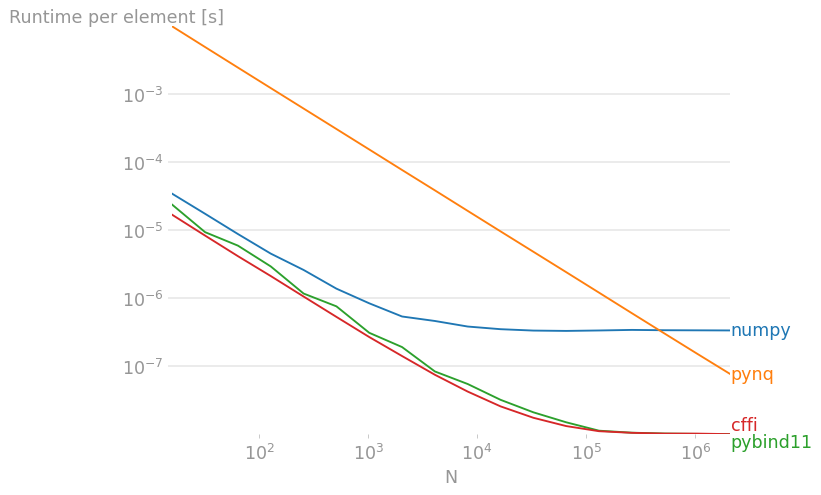

pynq_min = 262144
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.22136070500000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 3.436615000000000… │ 0.02373861750625… │ 0.013858758175000… │ 0.01385190285000… │
│ 32      │ 1.7462709375e-05   │ 0.01184800692500… │ 0.00692690040625   │ 0.006925871315625 │
│ 64      │ 8.804250000000001… │ 0.00591866575625  │ 0.00346470658125   │ 0.00346292346093… │
│ 128     │ 4.538606250000000… │ 0.00295926003281… │ 0.001732322272656… │ 0.00173150500078… │
│ 256     │ 2.611557812500000… │ 0.00148010540937… │ 0.000865865990625… │ 0.00086575255195… │
│ 512     │ 1.386878125e-06    │ 0.00074027455917… │ 0.000433107432226… │ 0.00043287859453… │
│ 1024    │ 8.447609375e-07    │ 0.00037018857744… │ 0.000216483988183… │ 0.00021644225195… │
│ 2048    │ 5.40568505859375e… │ 0.00018504519345… │ 0.000108278375976… │ 0.00010822805234… │
│ 4096    │ 4.644403808593750… │ 9.26491349121093… │ 5.412728955078125… │ 5.41183781005859… │
│ 8192    │ 3.84836279296875e… │ 4.62968003540039… │ 2.707659495849609… │ 2.70641602905273… │
│ 16384   │ 3.517579284667969… │ 2.31514611328125… │ 1.354302164306640… │ 1.35366039306640… │
│ 32768   │ 3.357139709472656… │ 1.15915173858642… │ 6.776510998535157… │ 6.77294309997558… │
│ 65536   │ 3.318426788330078… │ 5.80242315979004… │ 3.392760006713867… │ 3.39095239868164… │
│ 131072  │ 3.368384300231934… │ 2.90109469909668… │ 1.700184699249267… │ 1.69999128875732… │
│ 262144  │ 3.433197799682617… │ 1.44947771453857… │ 8.550160476684571… │ 8.54970230484008… │
│ 524288  │ 3.397350605010987… │ 7.25301665878296… │ 4.325048740386963… │ 4.32486833572387… │
│ 1048576 │ 3.38531183719635e… │ 3.63394846820831… │ 2.212706000328064… │ 2.21372237014770… │
│ 2097152 │ 3.371874127864838… │ 1.82524935722351… │ 1.156376679420471… │ 1.15639106082916… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

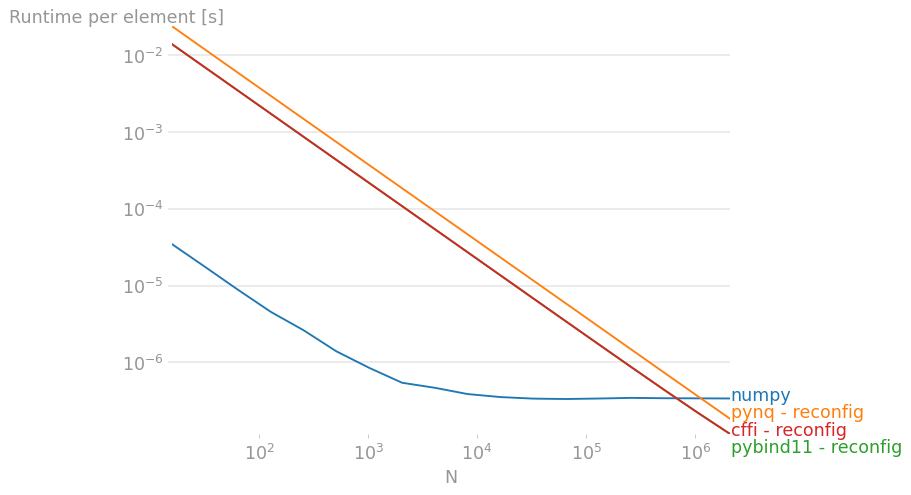

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [18]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)

from tools.download_bitfile import download_bitfile

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")  # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    x1 = allocate(shape=(n, ), dtype="f4")
    x2 = allocate(shape=(n, ), dtype="f4")

    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x2.shape)

    return x1, x2

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sad_f4_numpy, sad_f4_pynq, sad_f4_pybind11, sad_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns

    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]

print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_reduce_all_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")